<a href="https://colab.research.google.com/github/DevBhuyan/ISIC/blob/main/Copy_of_Segmentation_Unet(densenet121)_2016_trainset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install segmentation-models
!pip install --upgrade tensorflow
!pip install h5py==2.15

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 KB 2.5 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Could not find a version that satisfies the requirement h5py==2.15 (from versions: 2.2.1, 2.3.0b1, 2.3.0, 2.3.1, 2.4.0b1, 2.4.0, 2.5.0, 2.6.0, 2.7.0rc2, 2.7.0, 2.7.1, 2.8.0rc1, 2.8.0, 2.9.0rc1, 2.9.0, 2.10.0, 3.0.0rc1, 3.0.0, 3.1.0, 3.2.0, 3.2.1, 3.3.0, 3.4.0, 3.5.0, 3.6.0, 3.7.0, 3.8.0)
ERROR: No matching distribution found for h5py==2.15


In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


In [3]:
!unzip '/content/drive/MyDrive/ISIC 2016 for segmentation (testset).zip'

Archive:  /content/drive/MyDrive/ISIC 2016 for segmentation (testset).zip
   creating: ISIC 2016 for segmentation (testset)/
   creating: ISIC 2016 for segmentation (testset)/Test/
   creating: ISIC 2016 for segmentation (testset)/Test/MASKS/
  inflating: ISIC 2016 for segmentation (testset)/Test/MASKS/ISIC_0000003.jpg  
  inflating: ISIC 2016 for segmentation (testset)/Test/MASKS/ISIC_0000012.jpg  
  inflating: ISIC 2016 for segmentation (testset)/Test/MASKS/ISIC_0000013.jpg  
  inflating: ISIC 2016 for segmentation (testset)/Test/MASKS/ISIC_0000014.jpg  
  inflating: ISIC 2016 for segmentation (testset)/Test/MASKS/ISIC_0000015.jpg  
  inflating: ISIC 2016 for segmentation (testset)/Test/MASKS/ISIC_0000020.jpg  
  inflating: ISIC 2016 for segmentation (testset)/Test/MASKS/ISIC_0000022.jpg  
  inflating: ISIC 2016 for segmentation (testset)/Test/MASKS/ISIC_0000023.jpg  
  inflating: ISIC 2016 for segmentation (testset)/Test/MASKS/ISIC_0000027.jpg  
  inflating: ISIC 2016 for segmentati

In [4]:
! cp '/content/drive/MyDrive/Colab Notebooks/fetch_data.py' '/content/fetch_data.py'
! cp '/content/drive/MyDrive/Colab Notebooks/visualise.py' '/content/visualise.py'

In [5]:
%env SM_FRAMEWORK=tf.keras
import segmentation_models as sm
import tensorflow as tf
tf.config.run_functions_eagerly(True)
from fetch_data import fetch
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
import numpy as np
import matplotlib.pyplot as plt
from visualise import visualize, denormalize

env: SM_FRAMEWORK=tf.keras
Segmentation Models: using `tf.keras` framework.


In [8]:
base_dir = '/content/ISIC 2016 for segmentation (testset)/'
batch_size = 8
input_size = (224, 224)
num_epochs = 40
shuffle = True
ratio = 1
grp = 0
metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]
model_save = '2016_trainset_best_model.h5'

callbacks = [ModelCheckpoint('./'+model_save, 
                             monitor = "val_iou_score",
                             save_weights_only=True, 
                             save_best_only=True, 
                             mode='max',
                             initial_value_threshold = 0.0),
            ReduceLROnPlateau(monitor = "val_iou_score",
                             factor = 0.2,
                             patience = 3,
                             verbose = 1,
                             mode = 'max')]

In [9]:
train_dataset, validation_dataset = fetch(base_dir, input_size, grp, batch_size, shuffle, ratio)

train_images:  /content/ISIC 2016 for segmentation (testset)/Train/IMAGES/
no. of training images:  379
train_masks:  /content/ISIC 2016 for segmentation (testset)/Train/MASKS/
no. of training masks:  379
test_images:  /content/ISIC 2016 for segmentation (testset)/Test/IMAGES/
no. of test images:  379
test_masks:  /content/ISIC 2016 for segmentation (testset)/Test/MASKS/
no. of test masks:  379


/usr/local/lib/python3.8/dist-packages/tensorflow/python/data/ops/structured_function.py:256: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


In [10]:
model = sm.Unet(backbone_name = "densenet121",
                   input_shape=(224, 224, 3))

model.compile(optimizer=Adam(learning_rate = 4e-6), 
              loss=sm.losses.bce_dice_loss, 
              metrics=metrics)

print(len(model.layers))
model.summary()

29084464/29084464 [==============================] - 5s 0us/step
468
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                         

In [11]:
history = model.fit(train_dataset, epochs=num_epochs,
                    validation_data=validation_dataset,
                    callbacks=callbacks)

Epoch 1/40
48/48 [==============================] - 201s 4s/step - loss: 1.3330 - iou_score: 0.1775 - f1-score: 0.3001 - val_loss: 1.3602 - val_iou_score: 0.1197 - val_f1-score: 0.2084 - lr: 4.0000e-06
Epoch 2/40
48/48 [==============================] - 188s 4s/step - loss: 1.2740 - iou_score: 0.2204 - f1-score: 0.3601 - val_loss: 1.3424 - val_iou_score: 0.1330 - val_f1-score: 0.2279 - lr: 4.0000e-06
Epoch 3/40
48/48 [==============================] - 228s 5s/step - loss: 1.2172 - iou_score: 0.2797 - f1-score: 0.4358 - val_loss: 1.3208 - val_iou_score: 0.1747 - val_f1-score: 0.2855 - lr: 4.0000e-06
Epoch 4/40
48/48 [==============================] - 189s 4s/step - loss: 1.1537 - iou_score: 0.3490 - f1-score: 0.5159 - val_loss: 1.2810 - val_iou_score: 0.2337 - val_f1-score: 0.3591 - lr: 4.0000e-06
Epoch 5/40
48/48 [==============================] - 188s 4s/step - loss: 1.0793 - iou_score: 0.4294 - f1-score: 0.5992 - val_loss: 1.2240 - val_iou_score: 0.2884 - val_f1-score: 0.4209 - lr: 4

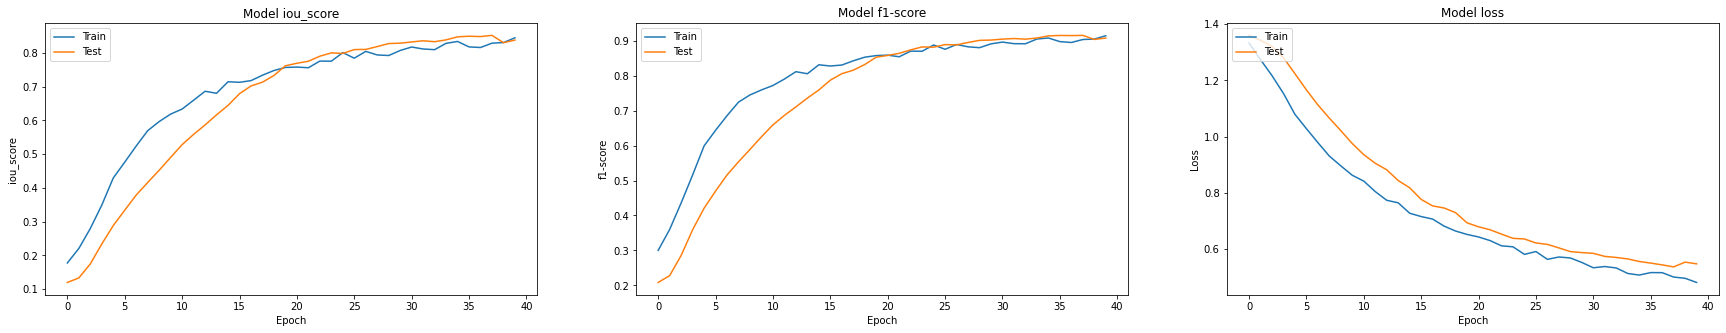

In [12]:
# Plot training & validation iou_score values
plt.figure(figsize=(30, 5))
plt.subplot(131)
plt.plot(history.history['iou_score'])
plt.plot(history.history['val_iou_score'])
plt.title('Model iou_score')
plt.ylabel('iou_score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation iou_score values
plt.subplot(132)
plt.plot(history.history['f1-score'])
plt.plot(history.history['val_f1-score'])
plt.title('Model f1-score')
plt.ylabel('f1-score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(133)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [13]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [14]:
model.load_weights(model_save) 

In [15]:
scores = model.evaluate(validation_dataset)

print("Loss: {:.5}".format(scores[0]))
for metric, value in zip(metrics, scores[1:]):
    print("mean {}: {:.5}".format(metric.__name__, value))

379/379 [==============================] - 108s 283ms/step - loss: 0.5363 - iou_score: 0.8523 - f1-score: 0.9155
Loss: 0.53634
mean iou_score: 0.8523
mean f1-score: 0.91554


1/1 [==============================] - 0s 233ms/step


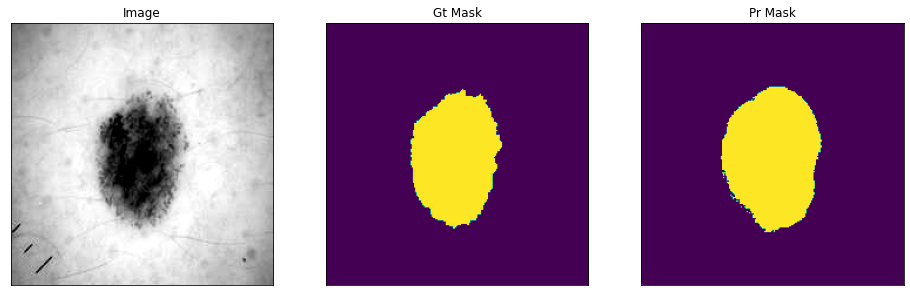

1/1 [==============================] - 0s 460ms/step


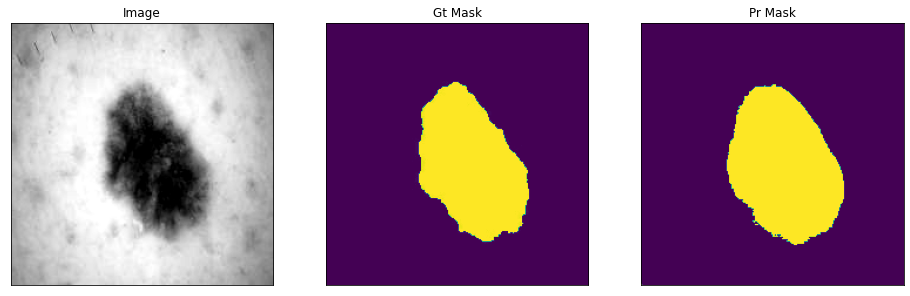

1/1 [==============================] - 0s 483ms/step


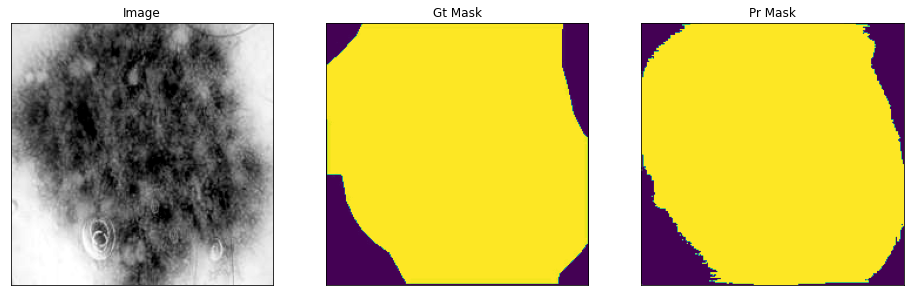

1/1 [==============================] - 0s 430ms/step


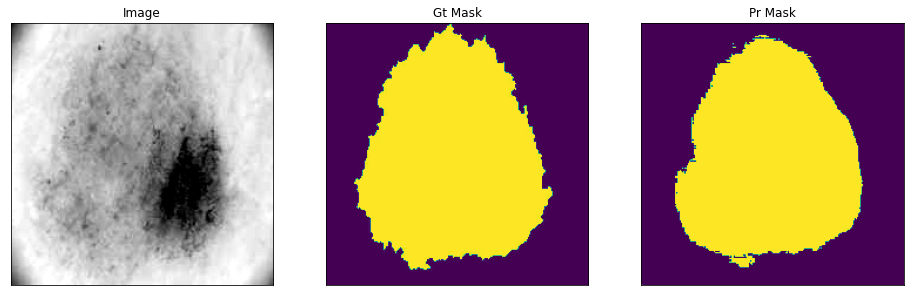

1/1 [==============================] - 1s 1s/step


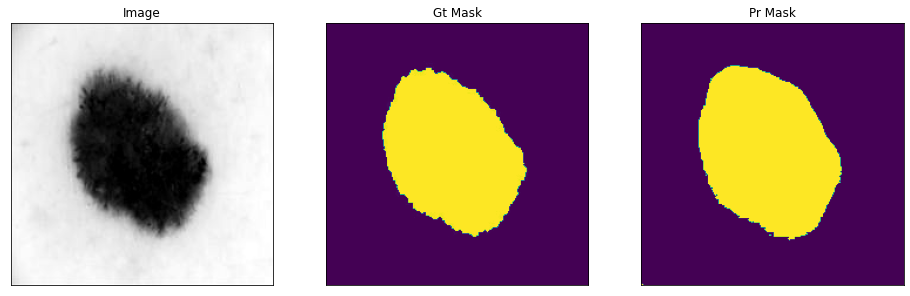

1/1 [==============================] - 1s 1s/step


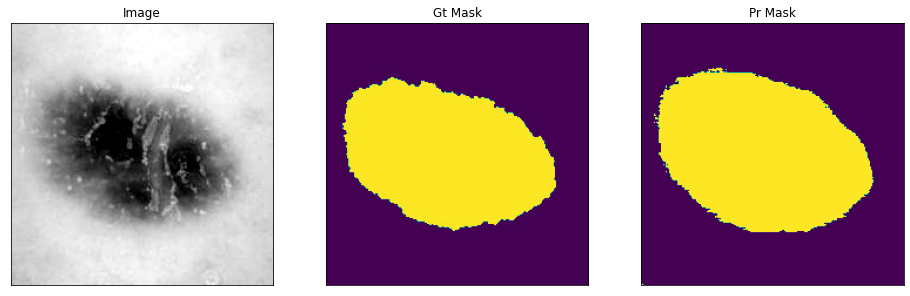

1/1 [==============================] - 0s 268ms/step


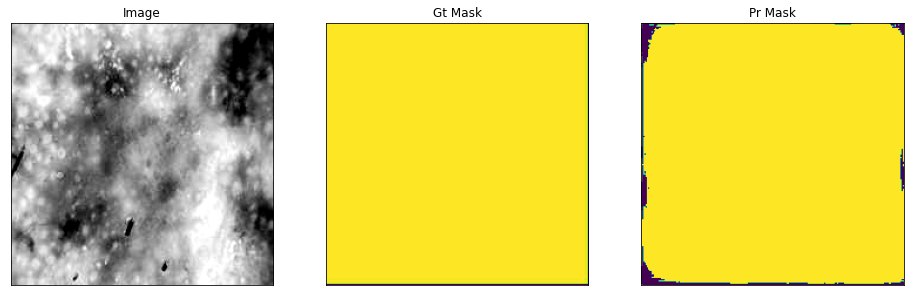

1/1 [==============================] - 0s 240ms/step


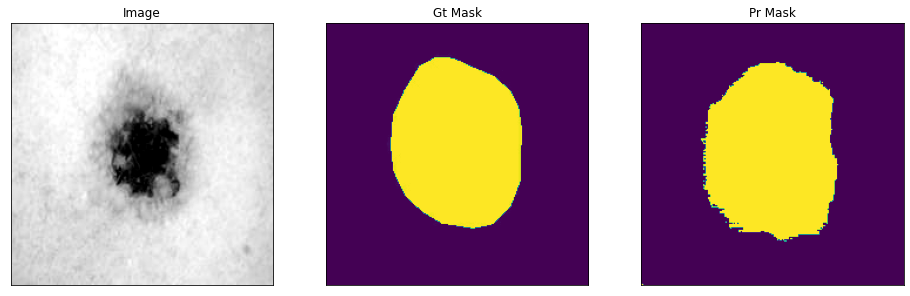

1/1 [==============================] - 0s 256ms/step


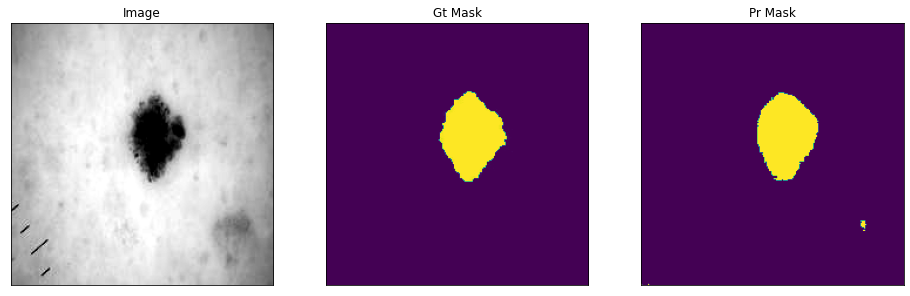

1/1 [==============================] - 0s 241ms/step


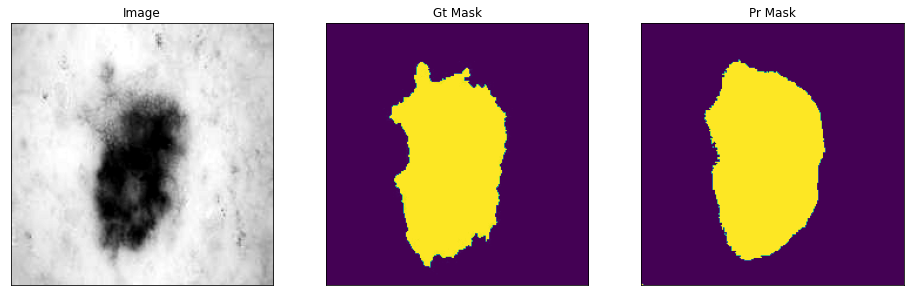

1/1 [==============================] - 0s 251ms/step


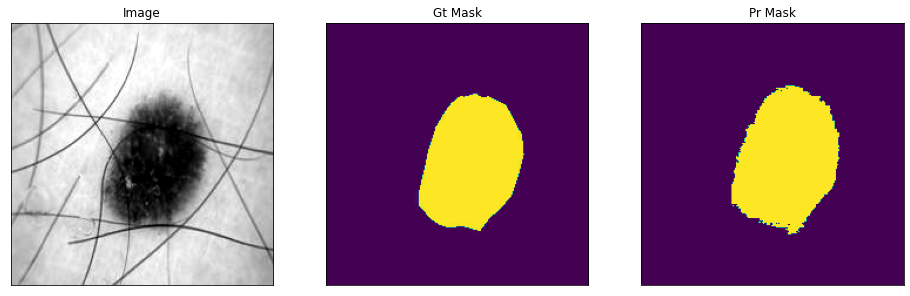

1/1 [==============================] - 0s 249ms/step


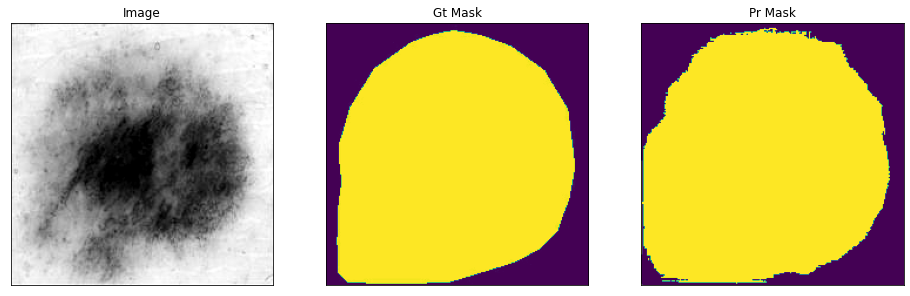

1/1 [==============================] - 0s 237ms/step


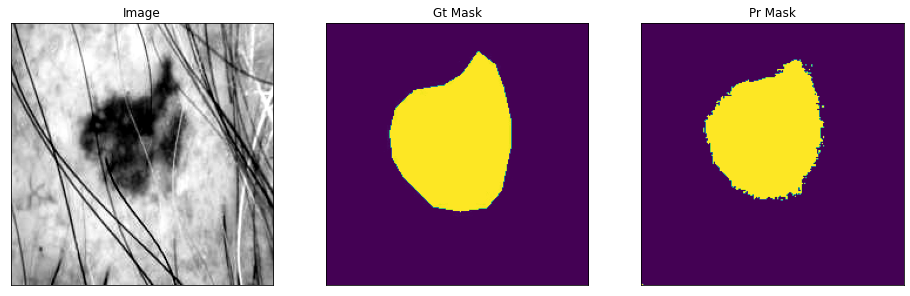

1/1 [==============================] - 0s 244ms/step


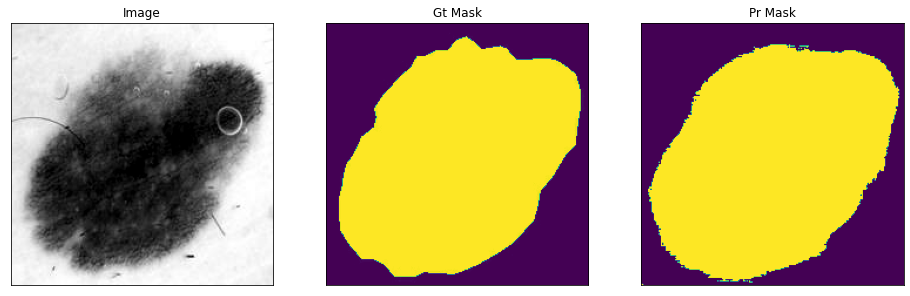

1/1 [==============================] - 0s 235ms/step


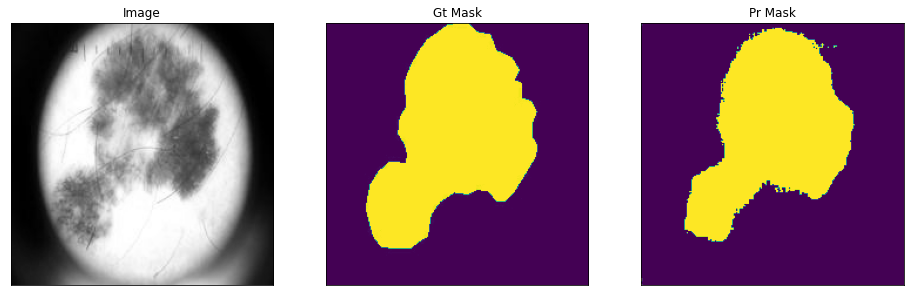

1/1 [==============================] - 0s 239ms/step


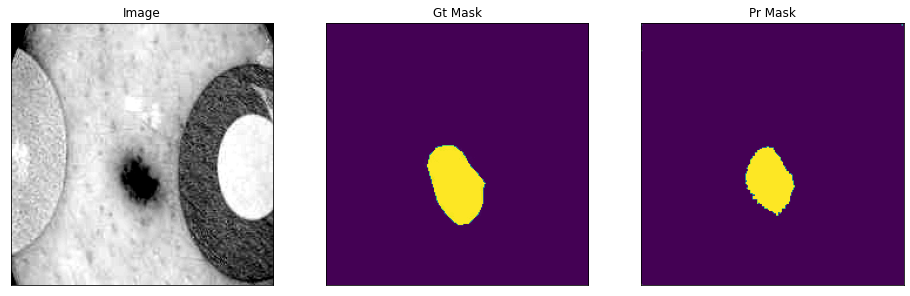

1/1 [==============================] - 0s 246ms/step


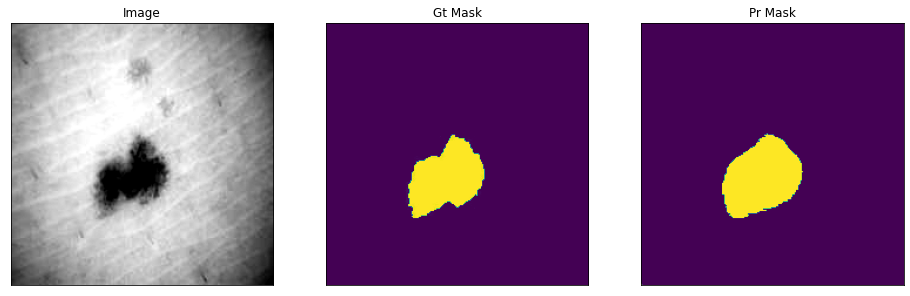

1/1 [==============================] - 0s 246ms/step


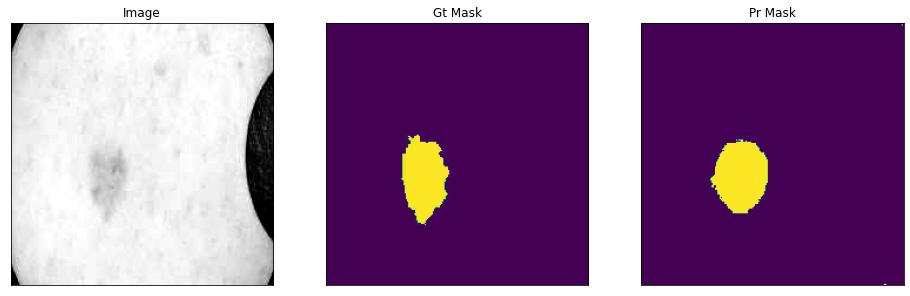

1/1 [==============================] - 0s 253ms/step


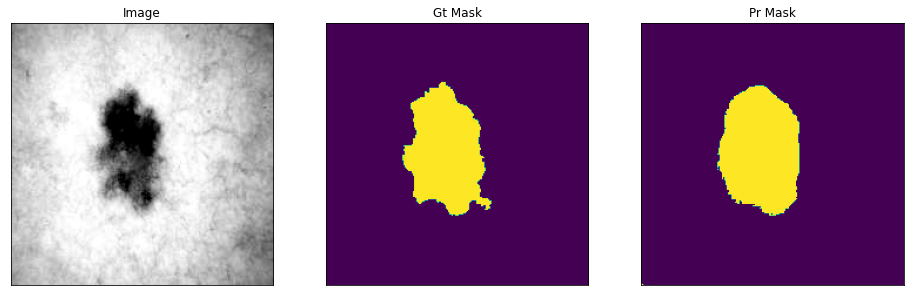

1/1 [==============================] - 0s 232ms/step


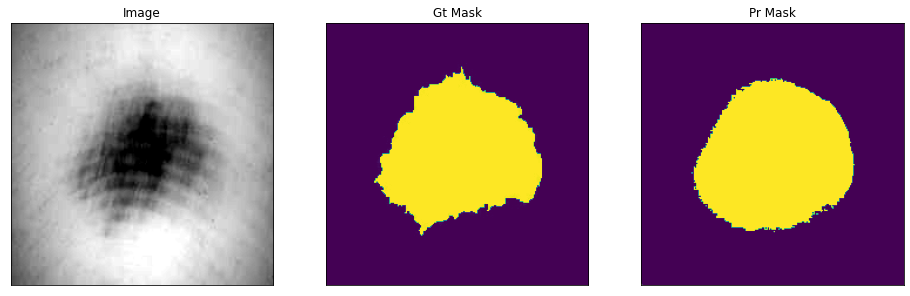

In [16]:
ct = 20
for batch in validation_dataset:
    image, gt_mask = batch
    image = image.numpy()
    gt_mask = gt_mask.numpy()
    pr_mask = model.predict(image).round()
    
    visualize(
        image=denormalize(image.squeeze()),
        gt_mask=gt_mask[..., 0].squeeze(),
        pr_mask=pr_mask[..., 0].squeeze(),
    )
    ct -= 1
    if ct == 0:
        break

In [17]:
# Change batch_size and change learning_rate to 2e-05
# Try focal loss, dice_loss
# Add more dropouts
# Reducing batch size to 8 helps, using encoder weights help
# mean iou_score: 0.45413; mean f1-score: 0.58879 with bce dice loss
# Try training it on extended dataset

In [18]:
'''base_dir = '/media/dev/WinD/Curious Dev B/PROJECT STAGE - II/ISIC 2017 for segmentation (python) (total)/'
train_dataset, validation_dataset = fetch(base_dir, input_size, grp, batch_size)
train_dataset = train_dataset.batch(1)
scores = model.evaluate(train_dataset)

print('Evaluating on entire dataset...')
print("Loss: {:.5}".format(scores[0]))
for metric, value in zip(metrics, scores[1:]):
    print("mean {}: {:.5}".format(metric.__name__, value))'''

'base_dir = \'/media/dev/WinD/Curious Dev B/PROJECT STAGE - II/ISIC 2017 for segmentation (python) (total)/\'\ntrain_dataset, validation_dataset = fetch(base_dir, input_size, grp, batch_size)\ntrain_dataset = train_dataset.batch(1)\nscores = model.evaluate(train_dataset)\n\nprint(\'Evaluating on entire dataset...\')\nprint("Loss: {:.5}".format(scores[0]))\nfor metric, value in zip(metrics, scores[1:]):\n    print("mean {}: {:.5}".format(metric.__name__, value))'